# Reinforcement Learning: Parcours de Golf

## Introduction

Un parcours de golf peut être simplement modélisé par un problème 2D qui peut être résolu grâce au Reinforcement Learning. L'objectif principal est de trouver une politique permettant de rentrer la balle dans le trou en un minimum de temps.

## Modélisation

### La structure

La modélisation du parcours de golf se fait simplement par une grille de taille $MxM$, où M est un entier compris dans l'intervalle $[2,7]$. Ensuite, la balle sera elle représentée par un $"1"$, tandis que le trou sera lui réprésenté par un $"2"$. Enfin, lorsque l'agent aura réussi à mettre la balle dans le trou, on trouvera alors un $"3"$ dans la grille, signifiant par ailleurs que la partie est terminée. Voici deux parcours de golf qui imagent nos choix.

Avec cette représentation, on distingue alors $MxM=M^2$ états possibles pour la balle et le trou, ce qui au total fait $M^4$ différents états pour notre grille. Du côté des actions, elles sont au nombre de 8 (en avant, en arrière, à droite, à gauche, diagonales droite et gauche, diagonales arrière droite et gauche). En combinant ces deux résulats, on trouve alors $8M^4$ pairs états/actions envisageables.
    
Lorsque l'agent réussira à mettre la balle dans le trou, on lui fournira une récompense de "1" puisqu'il aura rempli la contrainte de gain de la partie, tandis qu'on le récompensera d'un 0 dans le cas où il n'y arrive pas.

### Méthode de résolution

Pour résoudre le problème de golf, nous avons opté pour l'utilisation du Q-learning. En effet, l'objectif de l'agent est de parvenir à mettre la balle dans le trou en un minimum de coup possible. Pour cela à chaque interaction nous voulons choisir celle qui va nous permettre de nous rapprocher au plus du drapeau, jusqu'à l'atteindre. La traduction de cet objectif est donc qu'a chaque pas de temps, nous choisissons l'action qui nous permet de maximiser notre fonction de valeur à l'état d'après. Nous détaillerons ultérieuremet au sein de la partie dédier à l'architecture du code ce fonctionnement.

### Méthode d'exploitation

Le choix concernant cet aspect a été d'utiliser la méthode epsylon greedy, qui s'accorde parfaitement avec notre méthode de résolution. 

$\epsilon \%$ du temps nous allons choisir une action au hasard (phase d'exploration) et $1-\epsilon \%$ du temps nous prendrons le meilleur choix possible. 

Dans notre cas, l'utilisation d'une méthode Softmax nous ralentirait, du fait de devoir calculer à chaque pas de temps autant de probabilité que d'action. Néanmoins cette méthode permettrait d'avoir un choix de coup plus judicieux.

### Type d'algorythme

Nous avons choisi d'utiliser le principe de TD-learning. En effet, nous sommes en model-free avec un environnement qui devient de plus en plus grand avec la taille de la grille. Ainsi nous allons procéder par échantillonnage de celui-ci. Nous mettons alors à jour la fonction de valeur par le biais de cette formule:

$   
             V(S_t) = V(S_t) + \alpha(\gamma V(S_{t+1})-V(S_t))
$

avec comme paramètres:

-$\alpha$: le learning rate qu'on fixe dans un premier temps à 0.1 (valeur souvent utilisée)

-$\gamma$: le facteur d'actualisation qui nous permet  de prendre en compte les récompenses futures. Dans notre cas, nous voulons pénaliser un nombre de coups trop élevé, c'est pourquoi on choisit une valeure de 0.7

## Code

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

### Classe d'état

In [3]:
class State:
    
    ##Initialisation de la classe State
    def __init__(self,player,M):
        self.M = M #dimension
        
        #création aléatoire du board
        self.board = np.zeros(((M,M)))
        ball = (np.random.randint(0,M),np.random.randint(0,M))
        flag = (np.random.randint(0,M),np.random.randint(0,M))
        while(ball == flag):
            ball = (np.random.randint(0,M),np.random.randint(0,M))
            flag = (np.random.randint(0,M),np.random.randint(0,M))
        self.ball = [ball[0],ball[1]]
        self.flag = [flag[0],flag[1]]
        self.board[ball[0],ball[1]] = 1
        self.board[flag[0],flag[1]] = 2
        
        self.player = player
        self.isEnd = False
        self.boardHash = None
        self.nbShoot = 0
        self.parShoot = max(abs(self.ball[0]-self.flag[0]),abs(self.ball[1]-self.flag[1])) #nombre de coup optimal
        self.nbShoots = [] #nombre de shoot pour chaque partie lors de l'entrainement
        self.diffShoot = [] #difference nombre coup optimal, nombre de coup
        self.time = [] #temps d'execution
        
    ## Permet de placer le board sous la forme d'une vecteur linéaire, que l'on stockera dans un dictionnaire avec une valeur
    def getHash(self):
        self.boardHash = str(self.board.reshape(pow(self.M,2)))
        return self.boardHash
    
    ## On distingue ici toutes les positions où la balle peut se rendre
    def avaiblePositions(self):
        avaiablePos = []
        x = self.ball[0]
        y = self.ball[1]
        
        avaiablePos.append([x+1,y])
        avaiablePos.append([x+1,y-1])
        avaiablePos.append([x+1,y+1])
        avaiablePos.append([x-1,y])
        avaiablePos.append([x-1,y-1])
        avaiablePos.append([x-1,y+1])
        avaiablePos.append([x,y+1])
        avaiablePos.append([x,y-1])
            
        return avaiablePos
    
    ## On met ici a jour le board de jeu
    def updateBoard(self,action):
        
        self.board[self.ball[0],self.ball[1]] = 0
        self.ball[0] = action[0]
        self.ball[1] = action[1]
        

        if action == self.flag:
            self.board[action[0],action[1]] = 3 #cas où l'on a gagné une partie
        else:
            self.board[action[0],action[1]] = 1 #cas où l'on a déplacé la balle
        
        
    ## Fonction qui nous permet de savoir si la partie est terminée
    def checkIsEnd(self):
        if self.ball == self.flag: 
            self.isEnd = True
            self.player.win = True
        if self.nbShoot>=3*self.M:
            self.isEnd = True
            
    ## On récompense ici notre agent, 1 s'il gagne, 0 sinon
    def giveRewards(self):
        if self.player.win:
            reward = 1
        else:
            reward = 0
        self.player.feedReward(reward) 
        
    ## Remise à zéro des paramètres afin de pouvoir en débuter une nouvelle
    def reset(self):
        M = self.M
        self.board = np.zeros(((M,M)))
        ball = (np.random.randint(0,M),np.random.randint(0,M))
        flag = (np.random.randint(0,M),np.random.randint(0,M))
        while(ball == flag):
            ball = (np.random.randint(0,M),np.random.randint(0,M))
            flag = (np.random.randint(0,M),np.random.randint(0,M))
        self.ball = [ball[0],ball[1]]
        self.flag = [flag[0],flag[1]]
        self.board[ball[0],ball[1]] = 1
        self.board[flag[0],flag[1]] = 2
        self.isEnd = False
        self.boardHash = None
        self.nbShoot = 0
        self.parShoot = max(abs(self.ball[0]-self.flag[0]),abs(self.ball[1]-self.flag[1]))
    
    
    ## On check si le coup choisi par l'agent correspond à une case de la grille, ie s'il est ou non out of bounds
    def checkActionIntoBounds(self,action):
        x = action[0]
        y = action[1]
        if x>=0 and x<=self.M-1:
            if y>=0 and y<=self.M-1:
                return True
        return False
    
    ## Fonction d'entrainement de l'agent
    ## Dans un premier temps on récupère les positions envisageables, puis on choisis une action à l'aide de la fonction 
    ## chooseAction de l'agent. On test ensuite si elle est envisageableou on. Dans le cas où elle l'est, on update de le board.
    ## On enregistre ensuite le hashed Board dans la list de l'agent prévue à cet effet
    def play(self,rounds=100):
        startTime = time.time() #nous permet de chronométrer le temps d'éxecution
        for i in range(rounds):
            if i%10000 == 0:
                print("Rounds {}".format(i)) #état des lieux du nombre de parties
            while self.isEnd == False:
                self.nbShoot += 1
                avaiblePositions = self.avaiblePositions()
                action = self.player.chooseAction(avaiblePositions,self.board,self.flag,self.ball)
                if self.checkActionIntoBounds(action):
                    self.updateBoard(action)
                boardHash = self.getHash()
                self.player.states.append(boardHash)
                self.checkIsEnd()
            
            self.nbShoots.append(self.nbShoot)
            self.diffShoot.append(self.nbShoot - self.parShoot)
            self.time.append(time.time()-startTime)
            self.giveRewards()
            self.player.reset()
            self.reset()

    ## Fonction qui nous permet à nous de jouer         
    def playHuman(self):
        while self.isEnd==False:
            self.showBoard()
            self.nbShoot +=1
            avaiblePositions = self.avaiblePositions()
            print(avaiblePositions)
            print('choisir en fonction de la position où l"on veut aller')
            i = int(input())
            action = [self.ball[0],self.ball[1]]
            for k in range(len(avaiblePositions)):
                if k == i:
                    action = avaiblePositions[k]
            if self.checkActionIntoBounds(action):
                self.updateBoard(action)
            self.checkIsEnd()
            
            
        if self.player.win == True:
            print("Winner")
        else:
            print('Looser')
            
    ## Fonction permettant à l'agent de nous montrer ce qu'il a appri
    def playAlone(self):
        while self.isEnd == False:
            self.showBoard()
            self.nbShoot += 1
            avaiblePositions = self.avaiblePositions()
            action = self.player.chooseAction(avaiblePositions,self.board,self.flag,self.ball)
            if self.checkActionIntoBounds(action):
                self.updateBoard(action)
                boardHash = self.getHash()
                self.player.states.append(boardHash)
                self.checkIsEnd()
        if self.player.win == True:
            print("Winner")
        else:
            print('Looser')
        print("Le plus petit nombre de coup pour gagner est de ",self.parShoot)
        print("La partie a été gagné en ",self.nbShoot," coup")
        self.reset()
        
    ## Affichage du board
    def showBoard(self):
        for i in range(self.M):
            print('--------------------------')
            out = '|'
            for j in range(self.M):
                elem = self.board[i][j]
                if elem == 1:
                    token = ' O '
                elif elem == 2:
                    token = ' X '
                else:
                    token = '   '
                out += token + '|'
            print(out)
        print('--------------------------')

### Classe joueur

In [4]:
class Player:
    ## Fonction d'initialisation avec un exploration rate, un gamma et un learning rate
    def __init__(self, name, exp_rate=0.3,decayGamma=0.7,lr = 0.1):
        self.name = name
        self.win = False
        self.states = [] #on récupère le chemin
        self.exp_rate = exp_rate
        self.learningRate = lr
        self.decayGamma = decayGamma
        self.statesValue= {}
    
    ## Reset des paramètre du joueur
    def reset(self):
        self.states = []
        self.win = False
    
    ## Update du board lors du choix d'une action
    def updateBoard(self,board,action,flag,ball):
        board[ball[0],ball[1]] = 0
        if action == flag:
            board[action[0],action[1]] = 3
        else:
            board[action[0],action[1]] = 1
    
    ## Hashage du board
    def getHash(self, board):
        boardHash = str(board.reshape(pow(len(board),2)))
        return boardHash
    
    ## On fourni à l'agent une récompense lorsqu'il gagne la partie
    def feedReward(self,reward):
        for state in reversed(self.states):
            if self.statesValue.get(state) is None:
                self.statesValue[state] = 0
            self.statesValue[state] += self.learningRate*(self.decayGamma*reward - self.statesValue[state])
            reward = self.statesValue[state]
        
    ## On check si le coup est out of bounds
    def checkActionIntoBounds(self,action,M):
        x = action[0]
        y = action[1]
        if x>=0 and x<=M-1:
            if y>=0 and y<=M-1:
                return True
        return False
    
    ## Fonction qui permet à l'agent de choisir l'action qu'il va réaliser
    def chooseAction(self, avaiblePositions,board,flag,ball):
        #exploration de l'environnement par l'agent
        if np.random.uniform(0,1) <= self.exp_rate:
            action = avaiblePositions[np.random.choice(len(avaiblePositions))]
        #exploitation de l'environnement par l'agent
        else:
            # Ici on va tester toutes les actions envisageable et sélectionner celle qui maximise notre fonction de valeure
            # Pour cela, pour chaque avaible positions, on récupère le nouveau board et on va chercher sa value dans notre 
            # dictionaire, puis on sélectionne la meilleure possible
            
            values = [0 for i in range(8)]
            for i in range(8):
                p = avaiblePositions[i]
                nextBoard = board.copy()
                if self.checkActionIntoBounds(p,len(board)):
                    self.updateBoard(nextBoard,p,flag,ball)
                nextBoardHash = self.getHash(nextBoard)
                values[i] = 0 if self.statesValue.get(nextBoardHash) is None else self.statesValue.get(nextBoardHash)
            if values == [0,0,0,0,0,0,0,0]:
                action = avaiblePositions[np.random.choice(len(avaiblePositions))]
            else:
                idx = values.index(max(values))
                action = avaiblePositions[idx]
        return action
    
    ## Enregistrement de la politique
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.statesValue, fw)
        fw.close()
    
    ## Chargement de la politique
    def loadPolicy(self, file):
        fr = open(file,'rb')
        self.statesValue = pickle.load(fr)
        fr.close()

### Entrainement de l'agent et premiers résultats

In [5]:
N= 50000
P = Player("Luca")
St = State(P,7)

St.play(N)

P.savePolicy()

Rounds 0
Rounds 10000
Rounds 20000
Rounds 30000
Rounds 40000


In [6]:
x = [p for p in range(N)]
rollingMean = [np.mean(St.nbShoots[:i]) for i in range(N)] #moyenne des coups en fonction du temps
timeTraining = St.time
deltaTho = St.diffShoot

C:\Users\micci\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\micci\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


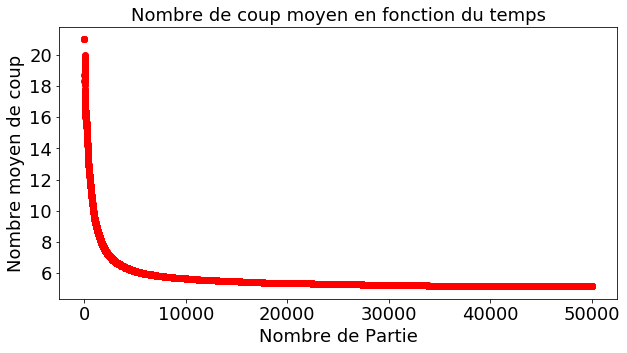

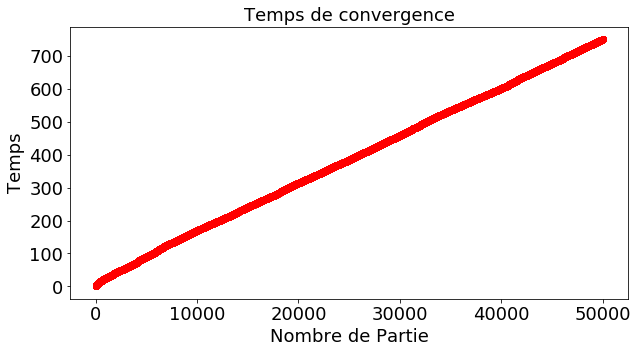

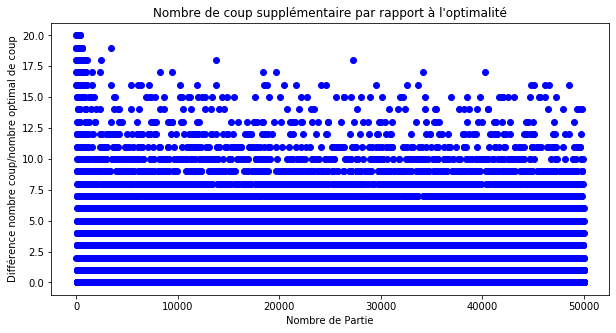

In [7]:
plt.figure(figsize=(10,5))
plt.title("Nombre de coup moyen en fonction du temps",size=18)
plt.xlabel("Nombre de Partie",size=18)
plt.ylabel("Nombre moyen de coup",size=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(x,rollingMean,"or")
plt.show()


plt.figure(figsize=(10,5))
plt.title("Temps de convergence",size=18)
plt.xlabel("Nombre de Partie",size=18)
plt.ylabel("Temps",size=18)
plt.plot(x,timeTraining,"or")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


plt.figure(figsize=(10,5))
plt.title("Nombre de coup supplémentaire par rapport à l'optimalité")
plt.xlabel("Nombre de Partie")
plt.ylabel("Différence nombre coup/nombre optimal de coup")
plt.plot(x,deltaTho,"ob")
plt.show()


Nous observons ici deux graphiques, l'un représentant le nombre de coups moyen d'une partie et l'autre le temps en fonction du nombre de parties. Sur une grille de taille $7x7$ on pourra s'attendre à une convergence lorsqu'en moyenne on arrive à gagner la partie en 5.5 coups. 

On peut alors voir que le nombre de coups moyen est une fonction décroissante du temps. On voit qu'au bout de $10'000$ parties on a déjà atteint un nombre de coups moyen de $6$ pour gagner la partie. On observe alors qu'on atteint un nombre de coups moyen au bout de:

In [8]:
K = 1
while rollingMean[K] > 5.5:
    K+=1
print("On atteint convergence au bout de ",K," partie, pour un temps d'execution de ",timeTraining[K]," secondes.")

On atteint convergence au bout de  13447  partie, pour un temps d'execution de  217.0623071193695  secondes.


On voit donc ici que l'agent à une politique qui converge à $K$ et qui à $K+500$ s'est encore améliorée.

NB:
    - on choisit ici de ne pas afficher la différence entre le nombre de coups et le nombre de coups optimaux du fait que la méthode epsilon nous fait faire des choix aléatoires pendant l'entrainement, et donc rend cet affichage illisible
    - Pour plus d'optimalité au niveau exécution, il faudra exécuter le code python en un seul bloc sur un IDE

### Optimisation des paramètres

Ici, nous allong essayer d'optimiser les paramètres $\alpha$ et $\gamma$.

#### Gamma

Dans notre cas, nous voulons fortement pénaliser un nombre de coups élevé. C'est pourquoi il semble logique que celui-ci se trouve plutôt dans l'intervalle $[0.5;1]$. Pour l'optimiser, nous allons donc tester une d'entraîner plusieurs agents avec un échantillonage de 0.1

In [9]:
N= 15000
gamma = np.linspace(0.5,1.0,6)
rollingMean = []
timeTraining = []
for g in gamma:
    P = Player("Luca",decayGamma= g)
    St = State(P,7)
    St.play(N)
    rollingMean.append([np.mean(St.nbShoots[:i]) for i in range(N)])
    timeTraining.append(St.time)

Rounds 0
Rounds 10000


C:\Users\micci\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\micci\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000


Pour un nombre de 15000 parties:

In [10]:
x = [p for p in range(N)]
for i in range(6):
    print("avec un gamma de",gamma[i], ", on trouve :",rollingMean[i][N-1])

avec un gamma de 0.5 , on trouve : 5.451563437562505
avec un gamma de 0.6 , on trouve : 5.476365091006067
avec un gamma de 0.7 , on trouve : 5.471831455430362
avec un gamma de 0.8 , on trouve : 5.539435962397493
avec un gamma de 0.9 , on trouve : 5.60457363824255
avec un gamma de 1.0 , on trouve : 5.614107607173811


Au vu des résultats obtenus via les tests des différents gamma, on s'aperçoit qu'avec une valeur de 0.6 ou 0.7 on obtient la meilleure convergence possible.

###### Nous choisissons alors $\gamma$ = 0.7, qui est la valeur initialement choisie

#### Alpha

In [11]:
N= 15000
alpha = np.linspace(0.0,0.3,6)
rollingMean = []
timeTraining = []
for a in alpha:
    P = Player("Luca",lr=a)
    St = State(P,7)
    St.play(N)
    rollingMean.append([np.mean(St.nbShoots[:i]) for i in range(N)])

Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000
Rounds 0
Rounds 10000


In [12]:
x = [p for p in range(N)]
for i in range(6):
    print("avec un alpha de",alpha[i], ", on trouve :",rollingMean[i][N-1])

avec un gamma de 0.0 , on trouve : 18.54290286019068
avec un gamma de 0.06 , on trouve : 5.601106740449363
avec un gamma de 0.12 , on trouve : 5.4790319354623644
avec un gamma de 0.18 , on trouve : 5.429361957463831
avec un gamma de 0.24 , on trouve : 5.309353956930462
avec un gamma de 0.3 , on trouve : 5.389559303953597


On trouve ici notre alpha en prenant le plus petit nombre de coups moyen, qui est de 0.12

### Modèle Final

#### Entraînement

In [13]:
alpha = 0.12
gamma = 0.7
M = 7
N = 15000

P = Player("computer",lr=alpha,decayGamma=gamma)
E = State(P,M)

E.play(N)
P.savePolicy()

Rounds 0
Rounds 10000


#### Test

In [14]:
testPlayer = Player("test",exp_rate=0)
testPlayer.loadPolicy("policy_computer")

TestState = State(testPlayer, 7)

In [15]:
TestState.playAlone()

--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   | X |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   | O |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   | X |   |   |
--------------------------
|   |   |   |   |   | O |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
Winner
Le plus petit nombre de coup pour gagner est de  2
La partie a été gagné en  2  coup


In [16]:
TestState.playAlone()

--------------------------
|   |   |   |   |   |   | O |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   | X |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   | O |   |
--------------------------
|   |   |   |   |   | X |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
Winner
Le plus petit nombre de coup pour gagner est de  2
La partie a été gagné en  2  coup


In [17]:
TestState.playAlone()

--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   |   |   |   |   |
--------------------------
|   |   |   | O |   |   |   |
--------------------------
|   |   | X |   |   |   |   |
--------------------------
Winner
Le plus petit nombre de coup pour gagner est de  1
La partie a été gagné en  1  coup


On voit alors que notre modèle permet de trouver à chaque fois le trou en un nombre de coups optimal